#  Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
import sys
from tqdm import tqdm
import pathlib

import matplotlib.pyplot as plt
%matplotlib inline
import cv2

from tensorflow import keras

from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.metrics import fbeta_score

# Data Import and Exploration 

In [2]:
train_df = pd.read_csv("/kaggle/input/planets-dataset/planet/planet/train_classes.csv")
test_df = pd.read_csv("/kaggle/input/planets-dataset/planet/planet/sample_submission.csv")

In [3]:
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
# Build list with unique labels
label_list = []
for tag_str in train_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [5]:
label_list

['haze',
 'primary',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'slash_burn',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'bare_ground',
 'artisinal_mine',
 'blooming',
 'selective_logging',
 'blow_down']

In [6]:
labels_derived = ['cultivation', 'clear', 'blooming', 'selective_logging', 'cloudy', 'conventional_mine', 'agriculture', 'artisinal_mine', 'water', 'haze', 'road', 'slash_burn', 'partly_cloudy', 'bare_ground', 'habitation', 'blow_down', 'primary']

In [7]:
label_map = {'cultivation': 0, 'clear': 1, 'blooming': 2, 'selective_logging': 3, 'cloudy': 4, 'conventional_mine': 5, 'agriculture': 6, 'artisinal_mine': 7, 'water': 8, 'haze': 9, 'road': 10, 'slash_burn': 11, 'partly_cloudy': 12, 'bare_ground': 13, 'habitation': 14, 'blow_down': 15, 'primary': 16}

In [8]:
# Add onehot features for every label
train_df2 = train_df.copy()
for label in label_list:
    train_df2[label] = train_df2['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
train_df2.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

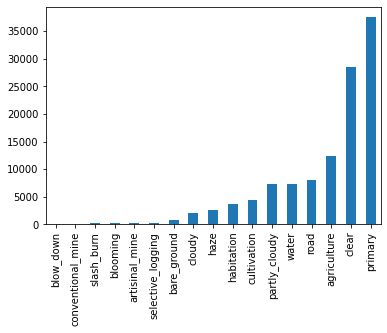

In [9]:
# Histogram of label instances
train_df2[label_list].sum().sort_values().plot.bar()

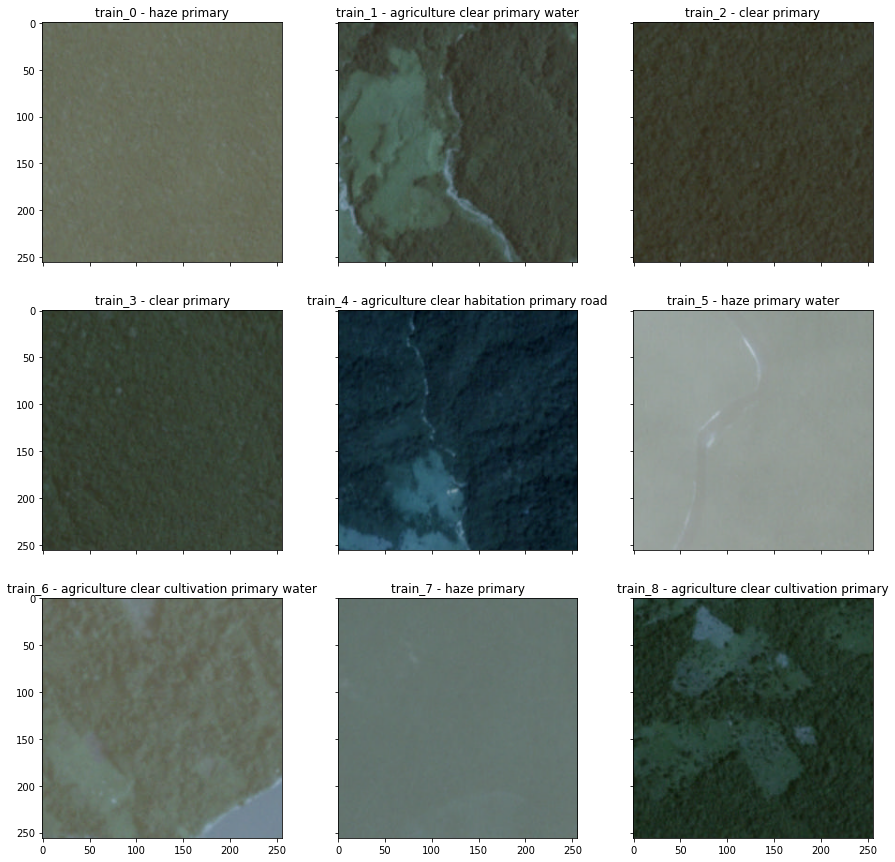

In [10]:
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(15, 15))
i = 0
for f, tags in train_df[:9].values:
    img = cv2.imread('/kaggle/input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f))
    ax[i // 3, i % 3].imshow(img)
    ax[i // 3, i % 3].set_title('{} - {}'.format(f, tags))
  
    i += 1
    
plt.show()

In [11]:
# Load the train-jpg file path

train_img_dir = pathlib.Path('/kaggle/input/planets-dataset/planet/planet/train-jpg')

train_img_path = sorted(list(train_img_dir.glob('*.jpg')))

train_img_count = len(train_img_path)
print(train_img_count)

40479


In [12]:
# first test jpg file path
test_img_dir = pathlib.Path('/kaggle/input/planets-dataset/planet/planet/test-jpg')

test_img_path = sorted(list(test_img_dir.glob('*.jpg')))

test_img_count = len(test_img_path)
print(test_img_count)

40669


In [13]:
# second test jpg file path

test_add_img_dir = pathlib.Path('/kaggle/input/planets-dataset/test-jpg-additional')

test_add_img_path = sorted(list(test_add_img_dir.glob('*/*.jpg')))

test_add_img_count = len(test_add_img_path)
print(test_add_img_count)

20522


In [14]:
# Ensuring the number of jpg images are equal to the number of samples in the csv file for each data set

# train
assert len(train_img_path) == len(train_df)

# test
assert len(test_img_path)+len(test_add_img_path) == len(test_df)

In [15]:
batch_size = 64

In [16]:
x_train = []
y_train = []

for f, tags in tqdm(train_df.values, miniters=1000):
    img = cv2.imread('/kaggle/input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f))
    img = cv2.resize(img, (64, 64))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    x_train.append(img)
    y_train.append(targets)
        
x_train = np.array(x_train, np.float32)
y_train = np.array(y_train, np.uint8)

print(x_train.shape)
print(y_train.shape)

100%|██████████| 40479/40479 [04:28<00:00, 150.83it/s]


(40479, 64, 64, 3)
(40479, 17)


In [17]:
import gc
gc.collect()

21

In [18]:
x_test = []

test_jpg_dir = '/kaggle/input/planets-dataset/planet/planet/test-jpg'
test_image_names = os.listdir(test_jpg_dir)

n_test = len(test_image_names)
test_classes = test_df.iloc[:n_test, :]
add_classes = test_df.iloc[n_test:, :]

test_jpg_add_dir = '/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional'
test_add_image_names = os.listdir(test_jpg_add_dir)

for img_name, _ in tqdm(test_classes.values, miniters=1000):
    img = cv2.imread(test_jpg_dir + '/{}.jpg'.format(img_name))
    x_test.append(cv2.resize(img, (64, 64)))
    
for img_name, _ in tqdm(add_classes.values, miniters=1000):
    img = cv2.imread(test_jpg_add_dir + '/{}.jpg'.format(img_name))
    x_test.append(cv2.resize(img, (64, 64)))

x_test = np.array(x_test, np.float32)
print(x_test.shape)

100%|██████████| 20522/20522 [02:00<00:00, 170.32it/s]


(61191, 64, 64, 3)


In [19]:
y=0
y

0

In [20]:


from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

# Model Building

In [21]:
import numpy as np
from keras import backend as K
from sklearn.metrics import fbeta_score

def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

In [22]:
#  model. 

from tensorflow import keras

from keras.layers import Conv2D, Dense, LSTM, Flatten, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD


model = keras.Sequential()
model.add(Conv2D(64, 5, 2, activation = "relu", input_shape = (64, 64, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(128, 5, 2, activation = "relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dense(17, activation = "sigmoid"))
model.compile(loss = "binary_crossentropy", optimizer = Adam(), metrics = [fbeta])
history = model.fit(X_train, Y_train, validation_data = (X_valid, Y_valid), epochs = 45, batch_size = 64)

2022-09-20 15:34:27.240127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 15:34:27.341218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 15:34:27.342069: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 15:34:27.343333: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/45


2022-09-20 15:34:34.795093: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


505/506 [============================>.] - ETA: 0s - loss: 0.2597 - fbeta: 0.6413

2022-09-20 15:34:43.463094: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 397934592 exceeds 10% of free system memory.
2022-09-20 15:34:44.198180: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 397934592 exceeds 10% of free system memory.


506/506 [==============================] - 12s 9ms/step - loss: 0.2595 - fbeta: 0.6412 - val_loss: 0.2012 - val_fbeta: 0.6876
Epoch 2/45
506/506 [==============================] - 3s 6ms/step - loss: 0.1915 - fbeta: 0.7049 - val_loss: 0.1742 - val_fbeta: 0.7292
Epoch 3/45
506/506 [==============================] - 3s 6ms/step - loss: 0.1720 - fbeta: 0.7412 - val_loss: 0.1656 - val_fbeta: 0.7713
Epoch 4/45
506/506 [==============================] - 3s 6ms/step - loss: 0.1645 - fbeta: 0.7520 - val_loss: 0.1624 - val_fbeta: 0.7512
Epoch 5/45
506/506 [==============================] - 4s 7ms/step - loss: 0.1587 - fbeta: 0.7608 - val_loss: 0.1588 - val_fbeta: 0.7555
Epoch 6/45
506/506 [==============================] - 3s 6ms/step - loss: 0.1543 - fbeta: 0.7678 - val_loss: 0.1530 - val_fbeta: 0.7780
Epoch 7/45
506/506 [==============================] - 3s 6ms/step - loss: 0.1496 - fbeta: 0.7757 - val_loss: 0.1542 - val_fbeta: 0.7690
Epoch 8/45
506/506 [==============================] - 3s 6

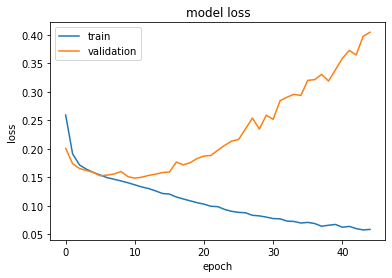

In [23]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [24]:
import gc
gc.collect()

4322

In [25]:
test_loss, test_accuracy = model.evaluate(X_valid, Y_valid)
print('Test loss: {}'.format(test_loss))
print('Test accuracy: {}'.format(test_accuracy))

2022-09-20 15:37:57.385754: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 397934592 exceeds 10% of free system memory.


253/253 [==============================] - 1s 3ms/step - loss: 0.4048 - fbeta: 0.7716
Test loss: 0.4048362970352173
Test accuracy: 0.7716382145881653


In [26]:
p_valid = model.predict(X_valid, batch_size = batch_size, verbose=1)

print(fbeta_score(Y_valid, np.array(p_valid) > 0.18, beta=2, average='samples')) 

127/127 [==============================] - 0s 2ms/step
0.8404542504366989


In [27]:
import gc
gc.collect()

781

In [28]:
y_pred = []
p_test = model.predict(x_test, batch_size=batch_size, verbose=2)
y_pred.append(p_test)

957/957 - 2s


In [29]:

pred_result = np.array(y_pred[0])
for i in range(1, len(y_pred)):
    pred_result += np.array(y_pred[i])
pred_result = pd.DataFrame(pred_result, columns=labels_derived)

In [30]:
pred_result

,cultivation,clear,blooming,selective_logging,cloudy,conventional_mine,agriculture,artisinal_mine,water,haze,road,slash_burn,partly_cloudy,bare_ground,habitation,blow_down,primary
0,4.532038e-02,8.584420e-01,8.007330e-03,1.510869e-02,5.509470e-03,2.143221e-08,4.523451e-02,1.451225e-05,1.051343e-01,6.006921e-02,2.855531e-02,3.290062e-04,2.883977e-02,6.137441e-02,6.880792e-03,5.731403e-04,0.981983
1,1.669116e-02,9.999998e-01,4.116687e-04,2.369504e-06,6.218833e-17,2.316703e-23,7.938256e-03,1.816668e-15,1.951505e-05,3.314630e-07,1.587459e-04,4.576815e-12,4.192135e-08,4.540496e-08,7.470789e-05,2.642432e-07,1.000000
2,2.822164e-19,6.942467e-36,2.612588e-32,0.000000e+00,0.000000e+00,0.000000e+00,1.520254e-28,0.000000e+00,8.618954e-10,1.075649e-33,4.243859e-37,0.000000e+00,1.000000e+00,7.296364e-17,5.343370e-32,0.000000e+00,1.000000
3,3.781752e-05,9.997882e-01,8.480759e-04,2.746861e-06,5.975756e-14,6.554595e-20,4.557862e-04,8.476574e-15,7.499459e-04,2.013408e-04,6.075616e-03,5.575676e-13,1.976635e-05,2.490817e-08,3.747378e-06,9.597896e-10,1.000000
4,3.593624e-08,1.867250e-07,6.626271e-20,1.967757e-17,2.087026e-05,1.334080e-08,1.842075e-04,2.248680e-18,1.692409e-04,1.539425e-09,2.040482e-02,2.591838e-08,1.000000e+00,1.891516e-15,7.507396e-07,1.065590e-18,0.999998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61186,1.423116e-07,8.893550e-10,1.579438e-12,1.439966e-16,4.120421e-01,2.891574e-17,2.872890e-06,8.346476e-19,8.988891e-04,3.177037e-06,1.289950e-05,8.995436e-13,9.999977e-01,1.132695e-10,4.979829e-09,3.357057e-09,0.997154
61187,2.204048e-07,1.000000e+00,5.064809e-26,6.600453e-30,0.000000e+00,0.000000e+00,1.285457e-04,7.161184e-27,9.999913e-01,6.943525e-36,4.223589e-04,0.000000e+00,3.320625e-23,1.408150e-17,6.978673e-13,0.000000e+00,1.000000
61188,6.996745e-04,9.997259e-01,1.123798e-03,5.943746e-06,7.432280e-15,1.368178e-16,1.161234e-03,1.981611e-15,3.209632e-03,1.346758e-06,2.032143e-04,7.864515e-11,8.530361e-06,1.851622e-07,5.291565e-06,1.871133e-09,1.000000
61189,9.544447e-04,2.190049e-03,2.604508e-17,1.712731e-12,9.093202e-01,4.853124e-18,3.734050e-03,1.111638e-16,1.343975e-02,1.206679e-01,3.155542e-03,1.089222e-16,1.036815e-05,2.178466e-09,5.238244e-04,1.851524e-14,0.095098


In [31]:
# Translating the probability predictions to the unique labels
preds = []
for i in tqdm(range(pred_result.shape[0]), miniters=1000):
    a = pred_result.loc[[i]]
    a = a.apply(lambda x: x>0.2, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))

100%|██████████| 61191/61191 [01:51<00:00, 549.91it/s]


In [32]:
test_df['tags'] = preds
test_df.sample(5)

,image_name,tags
3666,test_3666,cultivation clear agriculture partly_cloudy pr...
36976,test_36976,partly_cloudy primary
1171,test_1171,agriculture primary
37175,test_37175,clear agriculture water haze primary
41153,file_10432,cloudy haze primary


In [33]:
# Converting the dataframe to a csv file for submission
test_df.to_csv('Hamoye_StageD_submission.csv', index=False)